## AISC, Challenge of the Month (December, 2022)


### Introduction

- **Natural Language Processing (NLP):** Natural language processing (NLP) refers to the branch of Computer Science and more specifically, the branch of Artificial Intelligence or AI concerned with giving computers the ability to understand text and spoken words in much the same way human beings can.

- **Sentiment Analysis:** Sentiment analysis (or opinion mining) is a natural language processing (NLP) technique used to determine whether data is positive, negative or neutral. Sentiment analysis is often performed on textual data to help businesses monitor brand and product sentiment in customer feedback, and understand customer needs.

In this Notebook, we'll develop a **Sentiment Analysis Model** to categorize a tweet as **Negative or Positive**.


### Importing Required Libraries


In [1]:
# Utility Libraries
import re
import pickle
import numpy as np
import pandas as pd

# Visualization Libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Normalization Library
from nltk.stem import WordNetLemmatizer

# Libraries for Model
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


### Importing Dataset

The dataset used is a **Sentiment Dataset**. It contains 41,158 tweets extracted from the **Twitter API**. The tweets have been annoted and can be used to detect sentiment.

It contains the following 6 fields:

1. UserName
2. ScreenName
3. Location
4. TweetAt
5. OriginalTweet
6. Sentiment

We only need the **OriginalTweet** and **Sentiment Fields**. So, we'll discard the others.


In [2]:
# Importing Datasets and Merging them into one for Future Splitting
dataset1 = pd.read_csv('./data/test.csv', encoding='latin-1')
dataset1 = dataset1[['OriginalTweet', 'Sentiment']]
dataset2 = pd.read_csv('./data/train.csv', encoding='latin-1')
dataset2 = dataset1[['OriginalTweet', 'Sentiment']]
datasets = [dataset1, dataset2]
dataset = pd.concat(datasets)

# Sorting Dataset
dataset = dataset.sort_values(by=['Sentiment'])


In [3]:
# Checking the Unique Sentiments and Length
sentiments = set(dataset['Sentiment'])
print(sentiments, len(dataset))


{'Extremely Positive', 'Extremely Negative', 'Neutral', 'Negative', 'Positive'} 7596


In [4]:
# Removing Neutral Tweets
dataset = dataset[dataset['Sentiment'] != "Neutral"]


In [5]:
# Replacing Sentiments with 0 and 1.
dataset['Sentiment'] = dataset['Sentiment'].replace('Positive', 1)
dataset['Sentiment'] = dataset['Sentiment'].replace('Extremely Positive', 1)
dataset['Sentiment'] = dataset['Sentiment'].replace('Negative', 0)
dataset['Sentiment'] = dataset['Sentiment'].replace('Extremely Negative', 0)


In [6]:
# Viewing Dataset
dataset.head()


,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,0
478,Have been talking to lots of Trump supporters ...,0
1207,Things are getting real crazy right now. Toile...,0
483,In the current climate that is absolute stockp...,0
1205,Random thought: Is there some way for central ...,0


### Visualizing Sentiment Distribution


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

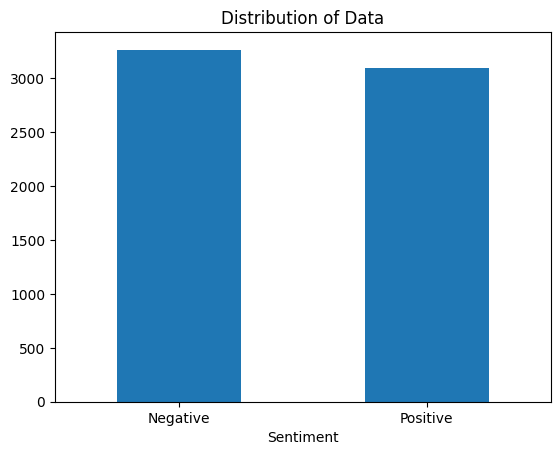

In [7]:
# Visualizing the Data based on the Distribution of Sentiments
ax = dataset.groupby('Sentiment').count().plot(
    kind='bar', title='Distribution of Data', legend=False)
ax.set_xticklabels(['Negative', 'Positive'], rotation=0)


In [8]:
# Storing Data in Lists
text, sentiment = list(dataset['OriginalTweet']), list(dataset['Sentiment'])


### Text Preprocessing

**Text Preprocessing** is traditionally an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

**The Preprocessing steps taken are:**

1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with "http" or "https" or "www" are replaced by "URL".
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg:
   to "EMOJIsmile")
4. **Replacing Usernames:** Replace @Usernames with word "USER". leg: '@KaggIe" to "USER")
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. leg: "Heyyyy" to "Heyy'9
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can
   safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. (e.g: 'Great" to "Good")


In [9]:
# Dictionary containing all Emojis with their Meanings
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised', ':-@': 'shocked', ':@': 'shocked', ':-$': 'confused', ':\\': 'annoyed', ':#': 'mute', ':X': 'mute', ':^)': 'smile',
          ':-&': 'confused', '$_$': 'greedy', '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused', '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', ';-)': 'wink', 'O:-)': 'angel', 'O*-)': 'angel', '(:-D': 'gossip', '=^.^=': 'cat'}

# English Stop Words
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'by', 'can', 'd', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from',  'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'more', 'most', 'my', 'myself', 'now', 'o', 'of', 'on',
                'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'own', 're', 's', 'same', 'she', "shes", 'should', "shouldve", 'so', 'some', 'such', 't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those',  'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', 'y', 'you', "youd", "youll", "youre", "youve", 'your', 'yours', 'yourself', 'yourselves']


In [10]:
# Defining Text Preprocessing Funtion
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer
    wordLemm = WordNetLemmatizer()

    # Regex patterns.
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern, ' URL', tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern, ' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword!
            if len(word) > 1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText


In [11]:
# Execution of Preprocessing
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing completed successfully!')
print(f'Time Taken: {round(time.time()-t)} Seconds')


Text Preprocessing completed successfully!
Time Taken: 3 Seconds


In [12]:
processedtext, len(processedtext)


(['trending new yorkers encounter empty supermarket shelf pictured wegmans in brooklyn sold out online grocer foodkick maxdelivery a coronavirus fearing shopper stock up URL URL ',
  'have been talking to lot of trump supporter across the country these last couple of day and the disdain for and distrust of the medium right now is worse than ve seen at any point throughout this presidency ',
  'thing are getting real crazy right now toilet paper is nowhere to be seen line are wrapping around the entire grocery store school are canceling our federal government is doing horrible job of containing covid 19 everyone is panicking ',
  'in the current climate that is absolute stockpiling chaos foodbanks are rapidly running out of supply just phoned my local food bank to see what they need so can pop some bit on my online order shopping list below if you re able to do the same covid19 coronavirus URL ',
  'random thought is there some way for central government to coordinate reassigning people

### Data Exploration and Analysis

Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.


#### Word-Cloud for Negative Tweets


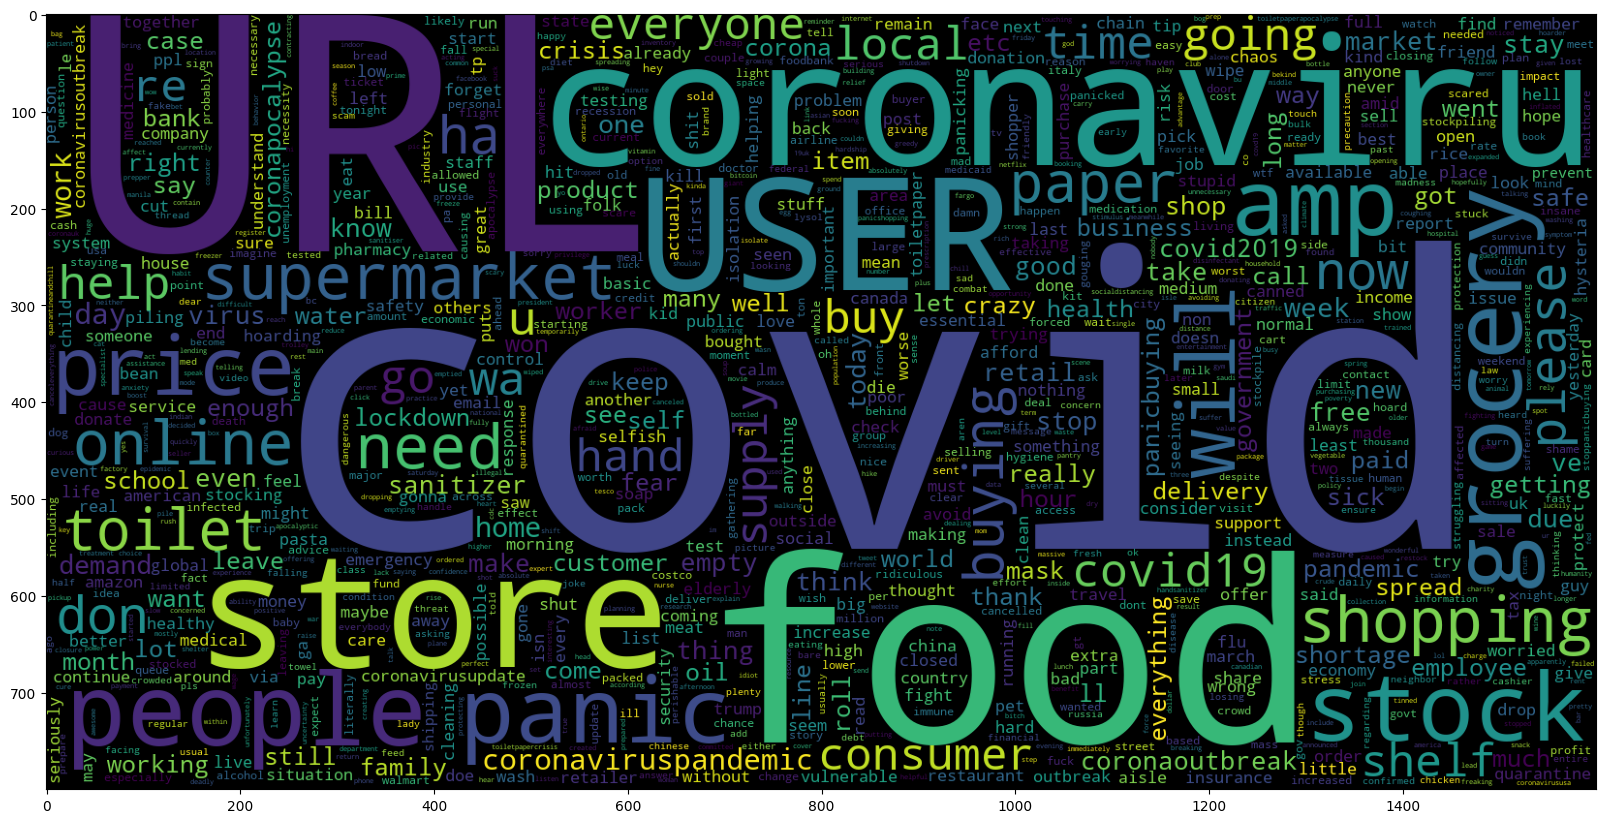

In [13]:
data_neg = processedtext[:len(dataset[dataset['Sentiment'] == 0])]
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)


#### Word-Cloud for Positive Tweets


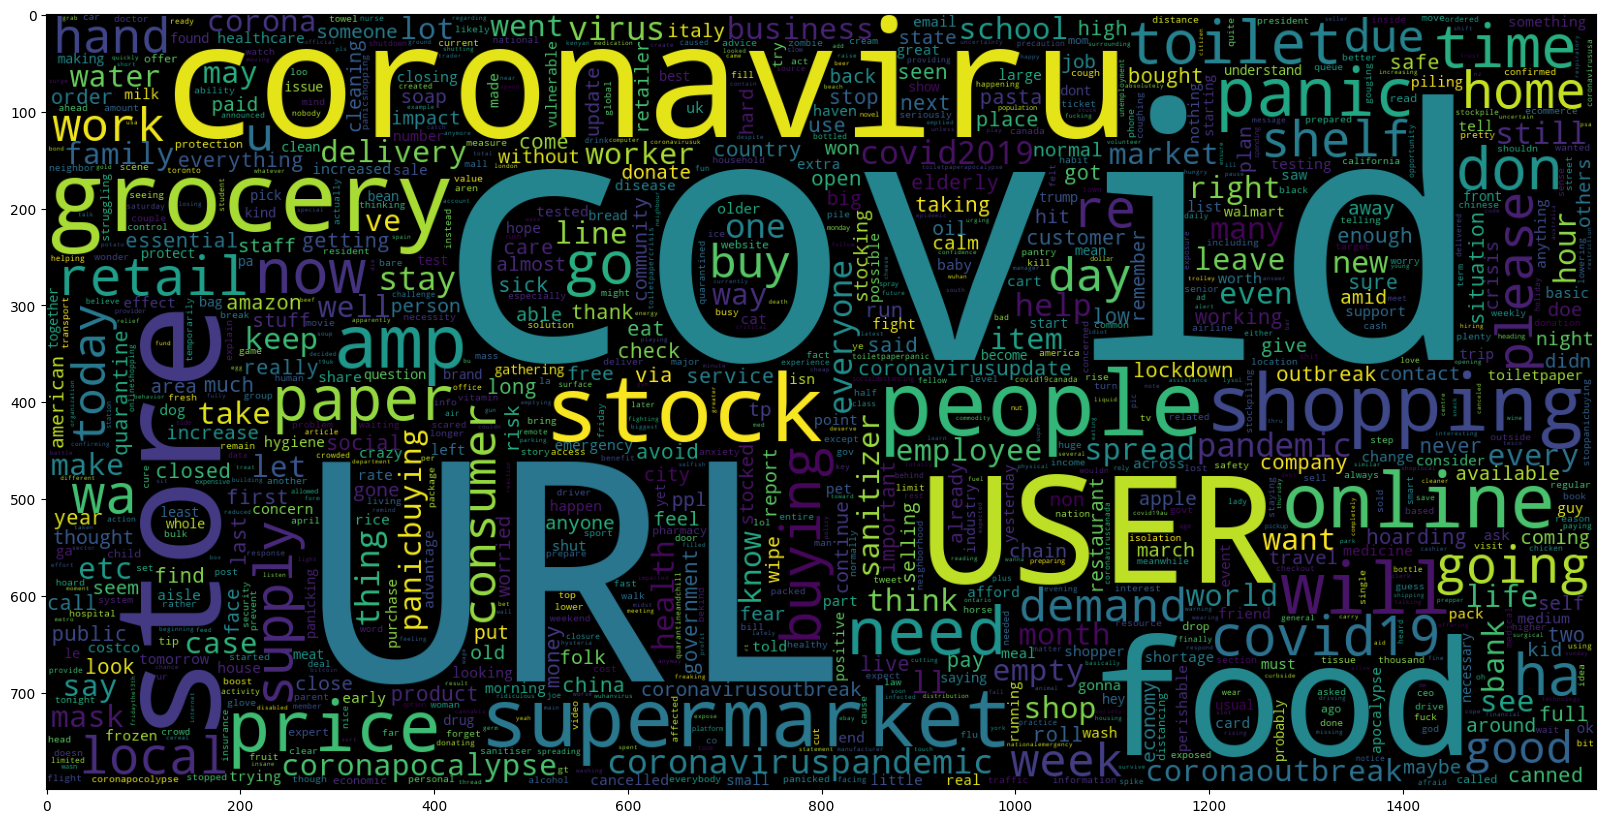

In [14]:
data_pos = processedtext[len(dataset[dataset['Sentiment'] == 0]):]
wc = WordCloud(max_words=1000, width=1600, height=800,
               collocations=False).generate(" ".join(data_pos))
plt.figure(figsize=(20, 20))
plt.imshow(wc)


### Splitting the Data

The Preprocessed Data is divided into 2 sets of data:

- **Training Data:** The dataset upon which the model would be trained on. Contains 95% data.
- **Testing Data:** The dataset upon which the model would be tested against. Contains 5% data.


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    processedtext, sentiment, test_size=0.05, random_state=0)
print(f'Data Splitting completed successfully...')


Data Splitting completed successfully...


### TF-IDF Vectorisation

**TF-IDF indicates what the importance of the word is in order to understand the document or dataset.** Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

**TF-IDF Vectoriser** converts a collection of raw documents to a **matrix of TF-IDF features**. The **Vectoriser** is usually trained on only the **X_train** dataset.

**ngram_range** is the range of number of words in a sequence. _[e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]_

**max_features** specifies the number of features to consider. _[Ordered by feature frequency across the corpus]_.


In [16]:
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature words: ', len(vectoriser.get_feature_names()))


Vectoriser fitted.
No. of feature words:  65112


c:\Users\prame\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Dataset Tranformation

Transforming the **X_train** and **X_test** dataset into matrix of **TF-IDF Features** by using the **TF-IDF Vectoriser**. This datasets will be used to train the model and test against it.


In [17]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)
print(f'Data Transformation completed...')


Data Transformation completed...


### Creating and Evaluating Models

We're creating 3 different types of model for our sentiment analysis problem:

- **Bernoulli Naive Bayes (BernoulliNB)**
- **Linear Support Vector Classification (LinearSVC)**
- **Logistic Regression (LR)**

Since our dataset is not **skewed**, i.e. it has equal number of **Positive and Negative** Predictions. We're choosing **Accuracy** as our evaluation metric. Furthermore, we're plotting the **Confusion Matrix** to get an understanding of how our model is performing on both classification types.


In [18]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion Matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(
        value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)


#### BernoulliNB Model


              precision    recall  f1-score   support

           0       0.94      0.99      0.96       158
           1       0.99      0.94      0.96       160

    accuracy                           0.96       318
   macro avg       0.96      0.96      0.96       318
weighted avg       0.96      0.96      0.96       318



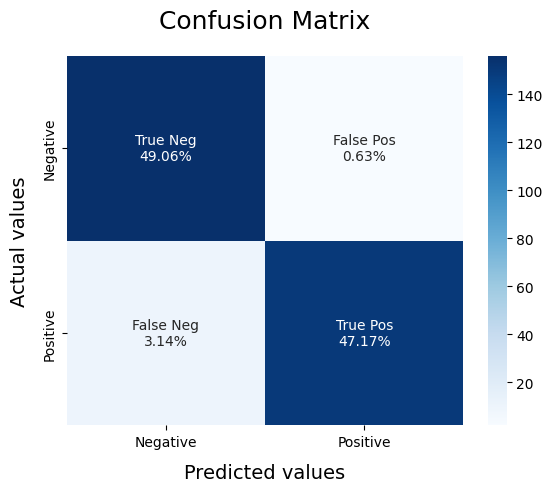

In [19]:
BNBmodel = BernoulliNB(alpha=2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)


#### LinearSVC Model


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       158
           1       1.00      0.97      0.99       160

    accuracy                           0.99       318
   macro avg       0.99      0.99      0.99       318
weighted avg       0.99      0.99      0.99       318



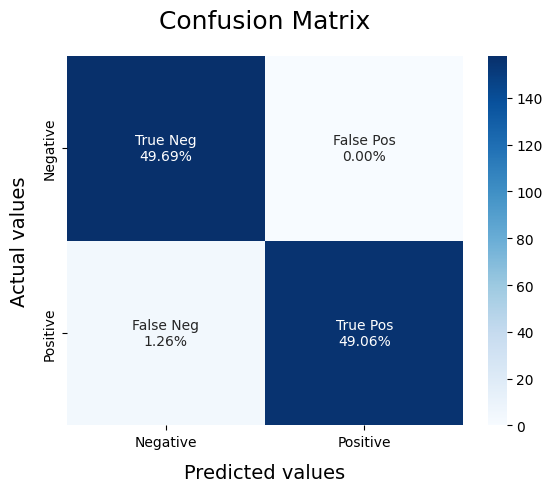

In [20]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)


#### Logistic Regression Model


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       158
           1       0.97      0.95      0.96       160

    accuracy                           0.96       318
   macro avg       0.96      0.96      0.96       318
weighted avg       0.96      0.96      0.96       318



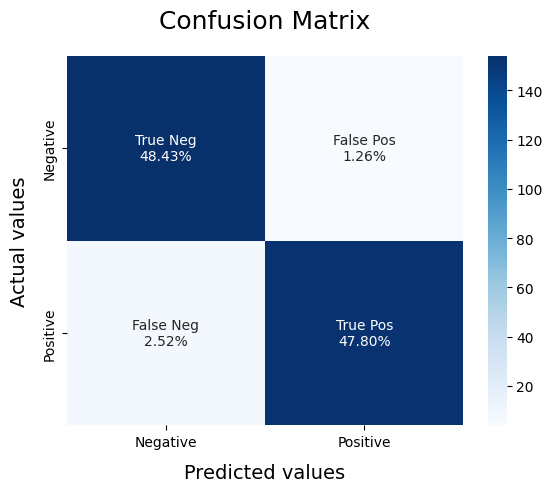

In [21]:
LRmodel = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)


We can clearly see that the **LinearSVC Model** performs the best out of all the different models that we tried. It achieves nearly **99% accuracy** while classifying the sentiment of a tweet.

Although it should also be noted that the **BernoulliNB Model** is the fastest to train and predict on. It also achieves **96% accuracy** while calssifying.


### Saving the Models

We're using **PICKLE** to save **Vectoriser** and **BernoulliNB**, **LinearSVC Model** for later use.


In [22]:
file = open('./models/vectoriser-ngram-(1,2).pickle', 'wb')
pickle.dump(vectoriser, file)
file.close()

file = open('./models/Sentiment-SVC.pickle', 'wb')
pickle.dump(SVCmodel, file)
file.close()

file = open('./models/Sentiment-BNB.pickle', 'wb')
pickle.dump(BNBmodel, file)
file.close()


### Using the Model

To use the model for **Sentiment Prediction** we need to import the **Vectoriser** and **LinearSVC Model** using **Pickle**.

The vectoriser can be used to transform data to matrix of TF-IDF Features.
While the model can be used to predict the sentiment of the transformed Data.
The text whose sentiment has to be predicted however must be preprocessed.


In [23]:
def load_models():
    # Load the vectoriser.
    file = open('./models/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('./models/Sentiment-SVC.pickle', 'rb')
    SVCmodel = pickle.load(file)
    file.close()

    return vectoriser, SVCmodel


def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)

    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text, pred))

    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns=['text', 'sentiment'])
    df = df.replace([0, 1], ["Negative", "Positive"])
    return df


if __name__ == "__main__":
    inp = input("Enter Text: ")
    # Text to classify should be in a list.
    text = [inp]

    df = predict(vectoriser, SVCmodel, text)
    print(df.head())


                     text sentiment
0  Twitter is very bad...  Negative


### <center>**================================================================**</center>

### <center>**THANK YOU**</center>

### <center>**================================================================**</center>
